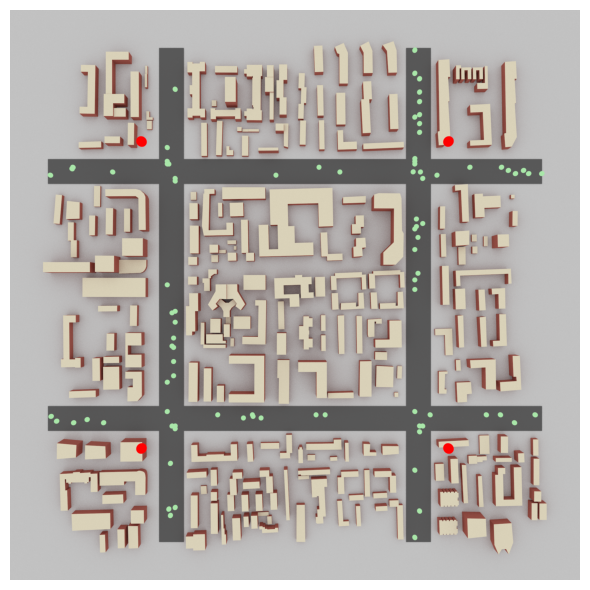

loaded scene_time= 200.0  process time= 17.175881385803223  s


In [ ]:
%matplotlib inline
import sys
sys.argv = ['run.py']
import time
import pickle
import matplotlib.pyplot as plt
import drjit as dr
import mitsuba as mi
import numpy as np
# Import or install Sionna
try:
    import sionna.rt
except ImportError as e:
    import os
    os.system("pip install sionna-rt")
    import sionna.rt

no_preview = True # Toggle to False to use the preview widget
                  # instead of rendering for scene visualization

from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera,\
                      RadioMapSolver, PathSolver, ITURadioMaterial, SceneObject, subcarrier_frequencies, watt_to_dbm

from utils.options import args_parser
from utils.sumo_utils import read_trajectoryInfo_timeindex

# 设置参数
N_t_H = 1  
N_t_V = 64  
N_r_H = 1   
N_r_V = 8   
tx_display_radius = 10
rx_display_radius = 5

args = args_parser()
args.trajectoryInfo_path = './sumo_data/trajectory_Lbd0.10.csv'
start_time=200
end_time=210
frequency = 28e9 # 5.9e9
pattern = "iso" # "tr38901"
h_car = 1.6
h_rx = 3
h_tx = 30

trajectoryInfo = read_trajectoryInfo_timeindex(
    args,
    start_time=start_time,
    end_time=end_time,
    display_intervel=0.05,
)
channel_gains_list = []

car_material = ITURadioMaterial("car-material",
                                "metal",
                                thickness=0.01,
                                color=(0.9, 0.9, 0.9))
road_material = ITURadioMaterial("road-material",
                                "concrete",
                                thickness=0.1,
                                color=(0.1, 0.1, 0.1))
#for scene_time in 500+0.1*np.array(list(range(10))):
scene = load_scene('scene_from_sionna.xml',merge_shapes=False)
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=N_t_H,
                            num_cols=N_t_V,
                            vertical_spacing=0.5,
                            horizontal_spacing=0.5,
                            pattern=pattern,
                            polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=N_r_H,
                            num_cols=N_r_V,
                            vertical_spacing=0.5,
                            horizontal_spacing=0.5,
                            pattern=pattern,
                            polarization="V")

# Create transmitter
tx1 = Transmitter(name="tx_1",
                position=[300,300,h_tx],
                display_radius=tx_display_radius)
tx2 = Transmitter(name="tx_2",
                position=[-300,300,h_tx],
                display_radius=tx_display_radius)
tx3 = Transmitter(name="tx_3",
                position=[300,-300,h_tx],
                display_radius=tx_display_radius)
tx4 = Transmitter(name="tx_4",
                position=[-300,-300,h_tx],
                display_radius=tx_display_radius)
tx1.look_at(mi.Point3f(0,0,0))
tx2.look_at(mi.Point3f(0,0,0))
tx3.look_at(mi.Point3f(0,0,0))
tx4.look_at(mi.Point3f(0,0,0))

# Add transmitter instance to scene
scene.add(tx1)
scene.add(tx2)
scene.add(tx3)
scene.add(tx4)


for scene_time in trajectoryInfo.keys():
    _time = time.time()
    # for name, obj in scene.objects.items():
    #     print(f'{name:<15}{obj.radio_material.name}')
    car_positions = []
    car_velocities = []
    rx_positions = []
    rx_velocities = []
    
    num_cars = len(trajectoryInfo[scene_time])
    cars = [SceneObject(fname=sionna.rt.scene.low_poly_car, # Simple mesh of a car
                    name=f"car-{i}",
                    radio_material=car_material)
        for i in range(num_cars)]
    scene.edit(add=cars)
    
    for i,v in enumerate(trajectoryInfo[scene_time].values()):
        car = cars[i]
        x, y = v['pos']
        v, angle = v['v'], v['angle']
        v_x, v_y = v*np.cos(angle), v*np.sin(angle)
        
        car.position = mi.Point3f(x.item(), y.item(), h_car)
        car.velocity = mi.Point3f(v_x.item(), v_y.item(), 0)
        car.orientation = mi.Point3f((angle/180-0.5)*np.pi, 0, 0)
        car_positions.append(car.position)
        car_velocities.append(car.velocity)
        rx_positions.append([x.item(),y.item(),h_rx])
        rx_velocities.append(car.velocity)
        
        # Create a receiver
        rx = Receiver(name=f"rx_{i+1}",
                    position=rx_positions[i],
                    orientation=[(angle/180-0.5)*np.pi,0,0],
                    display_radius=rx_display_radius,)
        # Add receiver instance to scene
        scene.add(rx)

    # tx.look_at(rx) # Transmitter points towards receiver

    scene.frequency = frequency # in Hz; implicitly updates RadioMaterials

    scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

    Road_horizontal1 = scene.get('Road_horizontal1')
    Road_horizontal1.radio_material = road_material
    Road_horizontal2 = scene.get('Road_horizontal2')
    Road_horizontal2.radio_material = road_material
    Road_vertical1 = scene.get('Road_vertical1')
    Road_vertical1.radio_material = road_material
    Road_vertical2 = scene.get('Road_vertical2')
    Road_vertical2.radio_material = road_material

    # # Compute propagation paths
    # p_solver = PathSolver()
    # paths = p_solver(scene, max_depth=5)
    # # OFDM system parameters
    # num_subcarriers = 1024
    # # num_subcarriers = 1
    # subcarrier_spacing=30e3
    # # Compute frequencies of subcarriers relative to the carrier frequency
    # frequencies = subcarrier_frequencies(num_subcarriers, subcarrier_spacing)
    # h_freq = paths.cfr(frequencies=frequencies,
    #                normalize=False,
    #                normalize_delays=True,
    #                out_type="numpy")
    # channel_gains = h_freq[:,:,:,:,0,0]
    # channel_gains_list.append(channel_gains)
    # for i,k in enumerate(trajectoryInfo[scene_time].keys()):
    #     trajectoryInfo[scene_time][k]['h'] = channel_gains[i,:,:]
    # scene.preview(paths=paths)

    # scene.edit(remove=cars)
    # for i,v in enumerate(trajectoryInfo[scene_time].values()):
    #     scene.remove(f"rx_{i+1}")
    
    if no_preview:
        # Render an image
        cam = Camera(position=[0,0,1000], look_at=[0,0,0])
        scene.render(camera=cam,
                    fov=60,
                    resolution=(2048, 2048),)
        plt.show()
    else:
        # Show preview
        scene.preview()
    
    
    print('loaded scene_time=',scene_time, ' process time=',time.time()-_time, ' s')
    
    
    break

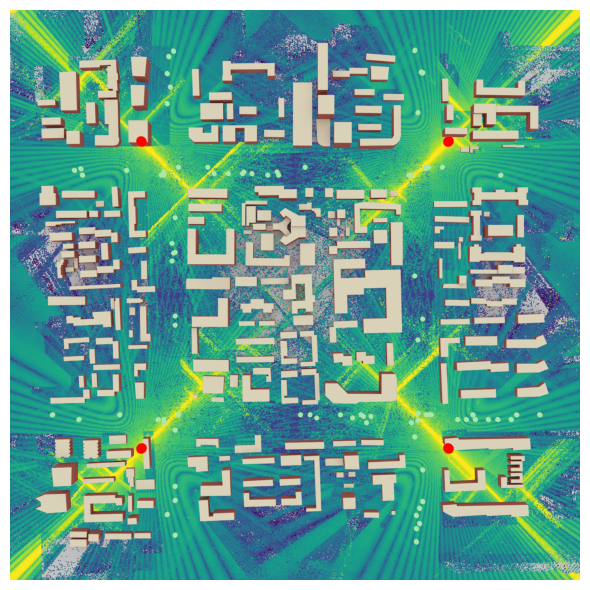

In [2]:
rm_solver = RadioMapSolver()

rm_etoile = rm_solver(scene,
                      max_depth=5,
                      samples_per_tx=10**7,
                      cell_size=(1, 1))

if no_preview:
    # Render an image
    cam = Camera(position=[0,0,1000],
                     orientation=np.array([0,np.pi/2,-np.pi/2]))
    scene.render(camera=cam,
                 fov=60,
                 resolution=(2048, 2048),
                    radio_map=rm_etoile,
                    rm_metric="sinr",
                    rm_vmin=-10,
                    rm_vmax=60)
    plt.show()
else:
    # Show preview
    scene.preview(radio_map=rm_etoile,
                         rm_metric="sinr",
                         rm_vmin=-10,
                         rm_vmax=60)

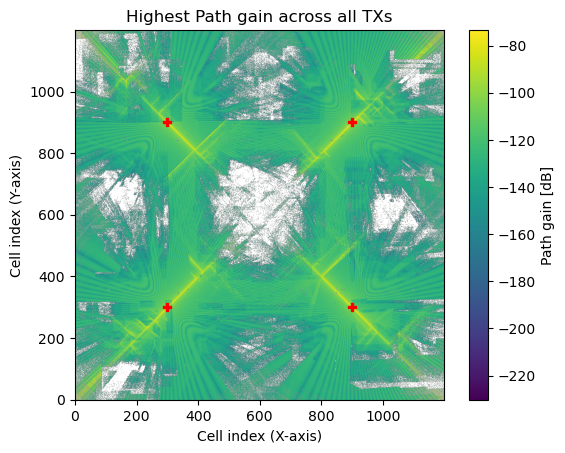

In [3]:
rm_etoile.show(metric="path_gain")
plt.show()